# Denoising Speech with NLMS and KLMS Adaptive Filters
*Ian Malone*

## Project Description

The purpose of this project is to design and evaluate the performance of a machine learning algorithm using the normalized LMS algorithm (or one of its variants) that will clean the desired input (speech plus noise) from the machine noise (input). This is an example of the interference canceling problem explained below.

Speech data is collected in a noisy room (loud vacuum cleaner) by two microphones: one on a table that captures speech with the vacuum cleaner noise (d(n)) and the other very close to the vacuum cleaner (n(n)) that basically has no speech. Even if you listen to d(n), the speech is barely audible, and the message is not understandable. The goal is to denoise d(n) and be able to understand the speech. It is suggested to use the signal n(n) as the input to the LMS algorithm and use d(n) as the desired response. 

## Project Steps

Start with a 2-tap filter:

 - Plots of the performance surface contours for the two weights filter case.
 - Plot the weight tracks
 - Plot the learning curve and interpret it.
 - Estimate the frequency response from the desired signal to the error when the filter is adapted.
 - Estimate the SNR improvement in dB by: 
    $ERLE=10\log(\frac{E[d^{2}]}{E[e^{2}]})$
    
Increase the filter order based on an analysis of performance. Explain your choice for the filter order.

 - Estimate again the frequency response from the desired signal to the error.
 - Compute the SNR improvement in dB
 - Evaluate the filter performance as a function of the stepsize.
 - Estimate the misadjustment.
 - Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 
You can use a FIR filter, a gamma filter or the KLMS to compare performance. 

## Project Implementation

In [1]:
# Import libraries
# mark

import scipy.io
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
np.random.seed(7)
%load_ext autotime

time: 0 ns (started: 2021-03-09 10:54:02 -05:00)


In [130]:
# define classes

class NLMS():
    
    def __init__(self, step_size, order):
        self.step_size = step_size
        self.order = order
        
    def learn(self, u, d):

        # initialize
        f = np.zeros(len(d))
        e = np.zeros(len(d))
        w = np.random.rand(self.order)
        w_trk = np.zeros((len(d)-self.order, self.order))

        # compute
        for i in range(1, len(d)-self.order):
            y = np.dot(w,u[i:i+self.order])
            e[i] = d[i+self.order] - y
            norm = ((np.linalg.norm(u[i:i+self.order])) ** 2)+0.1
            w = w + (self.step_size * e[i] * u[i])/norm   #normalize the step by the power of the input
            f[i] = y
            w_trk[i] = w 
        return f, w_trk, e

class GaussianKernel:
    def kernel(self, a, b):
        numer = (np.linalg.norm(a - b)) ** 2
        denom = (2 * self.sigma ** 2)
        return np.exp(-1 * (numer / denom))
    
class KLMS(GaussianKernel):
    
    def __init__(self, step_size, sigma, order): 
        self.step_size = step_size
        self.sigma = sigma
        self.order = order
       
    
    def learn(self, input_signal, desired_signal):
        # initialize
        estimates = np.zeros(len(input_signal))
        coefficients = np.zeros(len(input_signal))
        errors = np.zeros(len(input_signal))
        coefficients[0] = self.step_size * desired_signal[0]

        # compute
        for i in range(1, len(input_signal)-self.order):
            estimates[i-1] = 0
            for j in range(i-1):
                partial_sum = coefficients[j] * self.kernel(input_signal[i:i+(self.order-1)], input_signal[j:j+(self.order-1)])
                estimates[i-1] += partial_sum                 

            errors[i] = desired_signal[i+self.order] - estimates[i-1]
            coefficients[i] = self.step_size * errors[i]
        
        return estimates, coefficients, errors 
    
    
    
    
# define functions 
    
def ensemble_learning_curve(errors_matrix):
    # ensemble of adaptive filters with same configuration settings
    # get MSE vector for each filter
    # average MSE across filters
    errors = errors_matrix.mean(0)
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def freq_response(e, d, fs):
    return rfftfreq(len(e), 1/fs), abs(scipy.fft.rfft(e)/scipy.fft.rfft(d))

def gaussian_kernel(a, b, sigma):
    numer = (np.linalg.norm(a - b)) ** 2
    denom = (2 * sigma ** 2)
    return np.exp(-1 * (numer / denom))

def ERLE(d, e):
    return float(10*np.log10(sum(d**2)/sum(e**2)))

def learning_curve(errors):
    curve = []
    for i in range(len(errors)):
        curve.append(np.mean(errors[:i]**2))
    return curve

def klms_misadjustment(u, step_size, sigma):
    # klms: p38 text..  
    # data independent with shift-invariant kernels
    # with Gaussian kernel, this evaluates to 0.5*step_size
    kern = []
    for i in u:
        kern.append(gaussian_kernel(i, i, sigma))
    return step_size*0.5*(1/(len(u)))*np.sum(kern)

def klms_step(u, sigma):
    # p38 text
    kern = []
    for i in u:
        kern.append(gaussian_kernel(i, i, sigma))
    return len(u)/np.sum(kern)

def nlms_misadjustment(u, step_size):
    # nlms: p30 text.. 
    # 0.5*step_size*tr[R] = 0.5*step_size*mean*square
    return 0.5*step_size*np.mean(u**2)

def nlms_step(u):
    # p30 textbook
    return 1/(np.mean(u**2))

time: 0 ns (started: 2021-03-09 14:55:58 -05:00)


### Test the NLMS and KLMS on a Noisy Sine Wave

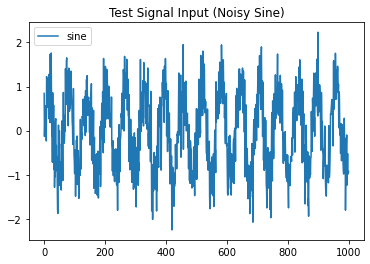

time: 125 ms (started: 2021-03-09 10:54:02 -05:00)


In [3]:
time = np.arange(0,100,0.1)
noisy_sine = np.sin(time)+np.random.normal(0,0.5,size=len(time))
plt.plot(noisy_sine, label='sine')

plt.title('Test Signal Input (Noisy Sine)')
plt.legend(loc='upper left')

In [4]:
nlms_test = NLMS(step_size=0.8, order=2)
outputs_test_n, weights_test_n, errors_test_n = nlms_test.learn(noisy_sine, noisy_sine)

time: 15 ms (started: 2021-03-09 10:54:02 -05:00)


In [6]:
klms_test = KLMS(step_size=0.2, sigma=2, order=3)
outputs_test_k, weights_test_k, errors_test_k = klms_test.learn(noisy_sine, noisy_sine)

time: 0 ns (started: 2021-03-09 10:54:03 -05:00)


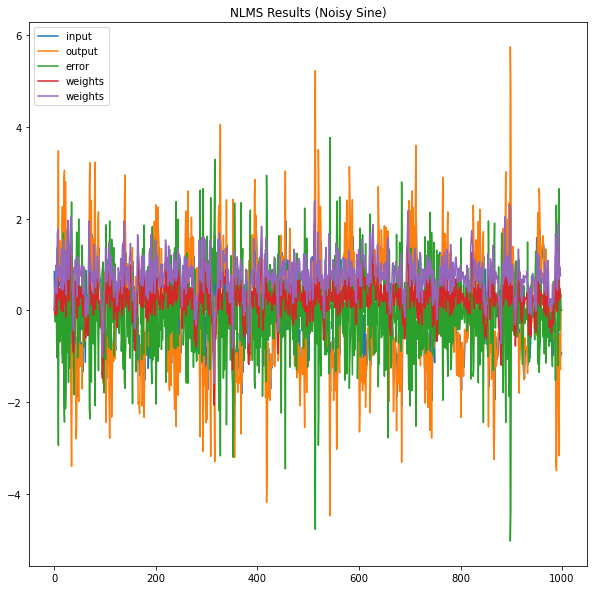

time: 171 ms (started: 2021-03-09 10:54:07 -05:00)


In [8]:
plt.figure(figsize=(10,10))

plt.plot(noisy_sine, label='input')
plt.plot(outputs_test_n, label='output')
plt.plot(errors_test_n, label='error')
plt.plot(weights_test_n, label='weights')

plt.title('NLMS Results (Noisy Sine)')
plt.legend(loc="upper left")

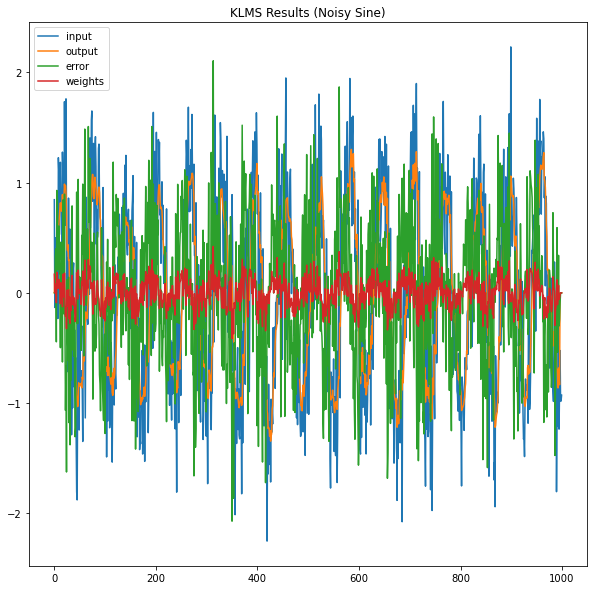

time: 157 ms (started: 2021-03-09 10:54:07 -05:00)


In [9]:
plt.figure(figsize=(10,10))

plt.plot(noisy_sine, label='input')
plt.plot(outputs_test_k, label='output')
plt.plot(errors_test_k, label='error')
plt.plot(weights_test_k, label='weights')

plt.title('KLMS Results (Noisy Sine)')
plt.legend(loc="upper left")

### Apply the NLMS and KLMS FIlters to the Noisy Speech Signal

#### Load data and apply NLMS and KLMS to test input/output

In [10]:
# The .mat file contains two channels with data labeled as desired (d) and input (n). 

filepath = 'C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Projects\\Project1\\project1.mat'
mat_data = scipy.io.loadmat(filepath)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'primary', 'reference'])
time: 0 ns (started: 2021-03-09 10:54:07 -05:00)


In [11]:
fs = int(mat_data['fs'][0])
# u is mostly noise input
# d is speech + noise desired
# error will be denoised speech

u = np.asarray(mat_data['primary'])[0,:]
d = np.asarray(mat_data['reference'])[0,:]

# good sections to test for speech
# [5000:10000]
# around 20000

time: 0 ns (started: 2021-03-09 10:54:07 -05:00)


In [12]:
ipd.Audio(d[:35000], rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 10:54:07 -05:00)


Text(0.5, 1.0, 'Primary and Reference Signals')

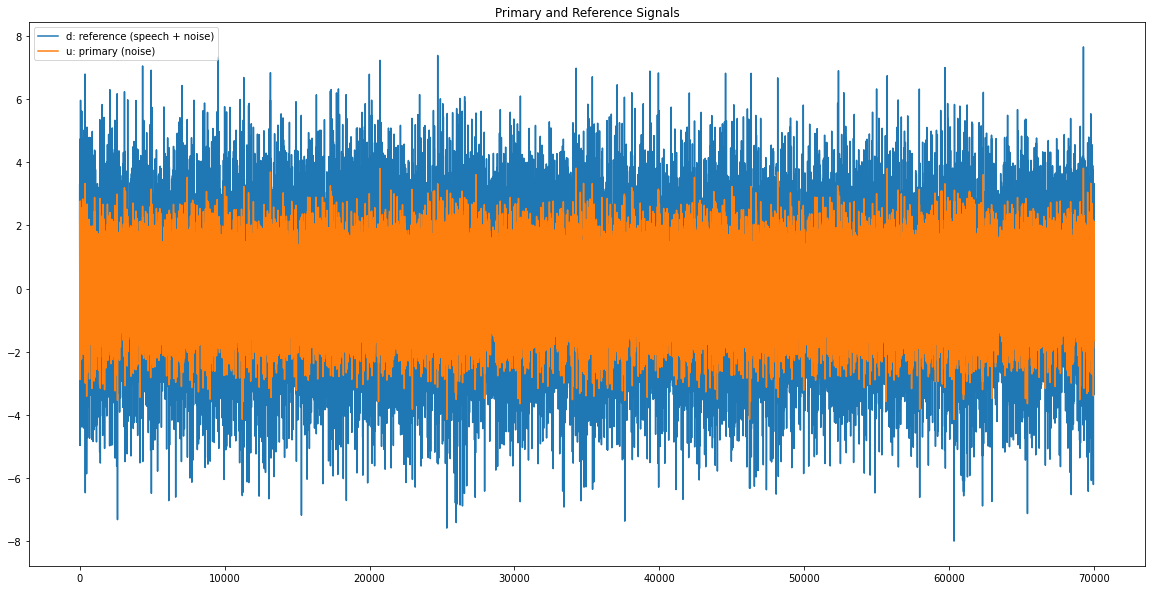

time: 469 ms (started: 2021-03-09 10:54:07 -05:00)


In [13]:
plt.figure(figsize=(20,10))

plt.plot(d, label='d: reference (speech + noise)')
plt.plot(u, label='u: primary (noise)')

plt.legend(loc="upper left")
plt.title('Primary and Reference Signals')

In [80]:
nlms_rough = NLMS(step_size=0.1, order=2)
outputs_n, weights_n, errors_n = nlms_rough.learn(u,d)

time: 657 ms (started: 2021-03-09 14:27:01 -05:00)


In [81]:
klms_rough = KLMS(step_size=0.1, sigma=1, order=2)
outputs_k, weights_k, errors_k = klms_rough.learn(u[5000:10000],d[5000:10000])
# 100 -> 0.047 s
# 1000 -> 4.5 s
# 10000 -> 6m47s
# 70000 -> 

time: 1min 41s (started: 2021-03-09 14:27:04 -05:00)


(5000.0, 15000.0)

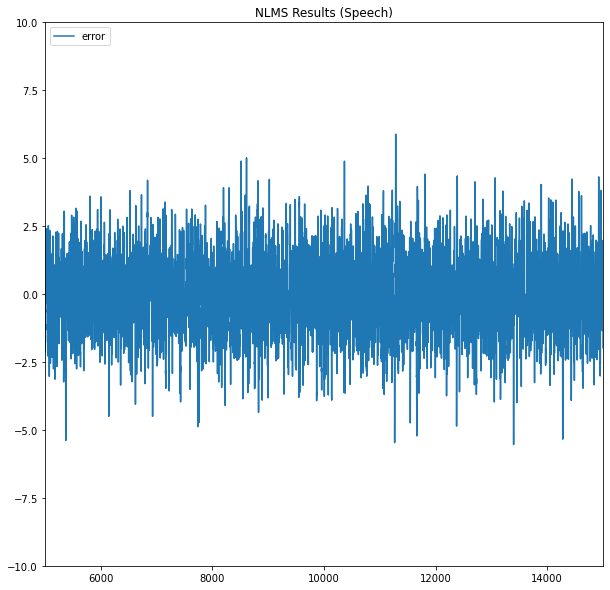

time: 125 ms (started: 2021-03-09 14:30:46 -05:00)


In [88]:
plt.figure(figsize=(10,10))

# plt.plot(u, label='input')
# plt.plot(outputs_n, label='output')
plt.plot(errors_n, label='error')
# plt.plot(weights_n, label='weights')

plt.title('NLMS Results (Speech)')
plt.legend(loc="upper left")
plt.ylim([-10,10])
plt.xlim([5000,15000])

(-10.0, 10.0)

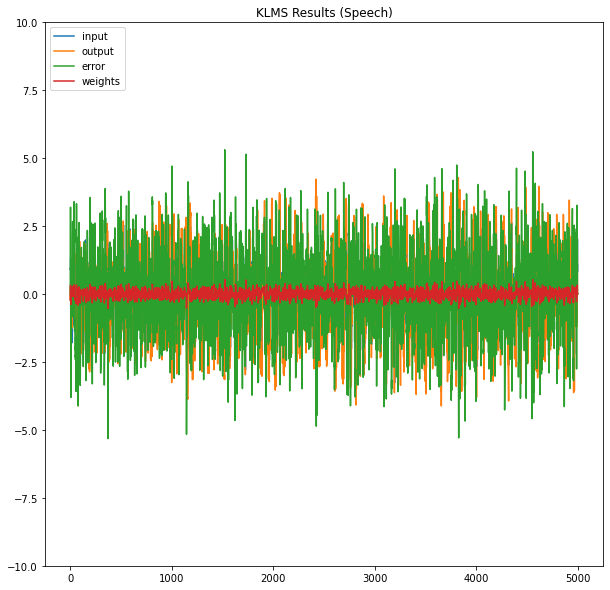

time: 171 ms (started: 2021-03-09 14:28:46 -05:00)


In [83]:
plt.figure(figsize=(10,10))

plt.plot(u[5000:10000], label='input')
plt.plot(outputs_k, label='output')
plt.plot(errors_k, label='error')
plt.plot(weights_k, label='weights')

plt.title('KLMS Results (Speech)')
plt.legend(loc="upper left")
plt.ylim([-10,10])

In [90]:
ipd.Audio(errors_k, rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 14:31:22 -05:00)


#### Compute upper bound of NLMS step size

In [79]:
"The maximum step size is %s." % nlms_step(u)

'The maximum step size is 0.9341501423053655.'

time: 0 ns (started: 2021-03-09 14:23:40 -05:00)


#### Create a 2-tap NLMS filter and choose parameters

In [166]:
reps = 10
steps = np.linspace(0.001, 0.1, num=10)
ERLEs = np.zeros((reps, len(steps)))

for i in range(reps):
    for j in range(len(steps)):
        nlms_two_tap = NLMS(step_size=steps[j], order=2)
        outputs_n, weights_n, errors_n = nlms_two_tap.learn(u,d)
        ERLEs[i,j] = ERLE(d, errors_n)

print('The best order-2 NLMS filter uses a step size of %s.' % steps[np.argmax(ERLEs.mean(axis=0))])

The best order-2 NLMS filter uses a step size of 0.001.
time: 1min 6s (started: 2021-03-09 15:24:47 -05:00)


In [167]:
nlms_two_tap = NLMS(step_size=0.001, order=2)
outputs_n, weights_n, errors_n = nlms_two_tap.learn(u,d)

time: 656 ms (started: 2021-03-09 15:26:47 -05:00)


#### Plot the performance surface contours for this filter

In [168]:
# import numpy as np 
# import pandas as pd 
# import matplotlib.pyplot as plt 
# from mpl_toolkits.mplot3d import Axes3D 
  
# # a = weights_n[:,0]
# # b = weights_n[:,1] 
  
# # a, b = np.meshgrid(a, b) 
  
# # # surface plot for a**2 + b**2 
# # a = np.arange(-10, 10, 0.02) 
# # b = a 
# # a, b = np.meshgrid(a, b) 
  
# # fig = plt.figure(figsize=(4,4)) 
# # axes = fig.gca(projection ='3d') 
# # axes.contour(a, b, np.sqrt(a-b)**2) 
  
# # plt.show() 


# # def nlms_perf_surf(d, y):
# #     return np.sqrt((d-y)**2)              
                        
# # define vectors
# x = weights_n[:,0]
# y = weights_n[:,1]
# z = error_n**2
                   
# # make 3D surface plot
# fig = plt.figure(figsize =(10,10)) 
# ax = plt.axes(projection ='3d') 
# ax.plot_trisurf(x, y, z, linewidth=0, antialiased=False)

# # look at lms/nlms slides... first slide has "simple estimate of performance surface"

time: 0 ns (started: 2021-03-09 15:26:50 -05:00)


#### Plot the weight tracks

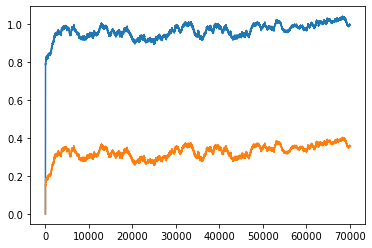

time: 109 ms (started: 2021-03-09 15:27:04 -05:00)


In [170]:
weights_1 = weights_n[:,0]
weights_2 = weights_n[:,1]

plt.plot(weights_1)
plt.plot(weights_2)

# check this, should be clean line, might not converge

#### Plot the learning curve

C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ian\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Ensemble NLMS, speech')

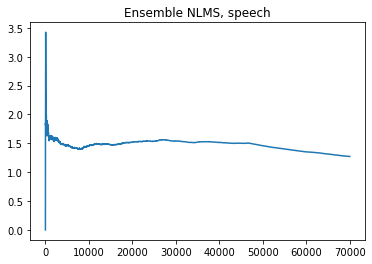

time: 5.61 s (started: 2021-03-09 15:27:11 -05:00)


In [171]:
outputs_n, weights_n, error = nlms_two_tap.learn(u,d)

reps = 5
for i in range(reps):
    outputs_n, weights_n, errors_n = nlms_two_tap.learn(u,d)
    error = np.vstack((error, errors_n))

plt.plot(ensemble_learning_curve(error), label='Ensemble NLMS, speech')
plt.title('Ensemble NLMS, speech')

#### Estimate the frequency response

Text(0.5, 0, 'Frequency (Hz)')

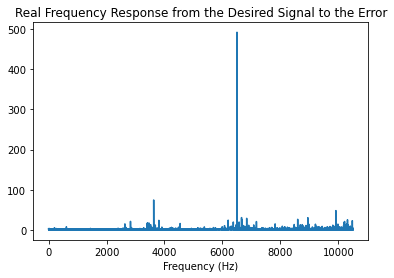

time: 93 ms (started: 2021-03-09 15:27:19 -05:00)


In [172]:
x, y = freq_response(errors_n, d, fs)

plt.plot(x,y)
plt.title('Real Frequency Response from the Desired Signal to the Error')
plt.xlabel('Frequency (Hz)')

#### Estimate SNR improvement in dB

In [173]:
'The SNR improvement after removing the noise using an order-2 NLMS filter is %s dB.' % ERLE(d, errors_n)

'The SNR improvement after removing the noise using an order-2 NLMS filter is 4.320433112898413 dB.'

time: 32 ms (started: 2021-03-09 15:27:25 -05:00)


#### Increase filter order

In [176]:
# search for a better performing filter order

reps = 10
orders = [2,3,4,5,6,7,8,9,10]
ERLEs = np.zeros((reps, len(orders)))

for i in range(reps):
    for j in range(len(orders)):
        nlms_new_tap = NLMS(0.001, order=orders[j])
        outputs_n, weights_n, errors_n = nlms_new_tap.learn(u,d)
        ERLEs[i,j] = ERLE(d, errors_n)

print('The best performing NLMS filter uses an order of %s.' % orders[np.argmax(ERLEs.mean(axis=0))])

The best performing NLMS filter uses an order of 2.
time: 59.3 s (started: 2021-03-09 15:30:49 -05:00)


#### Find a good step size for this order filter

In [156]:
reps = 10
steps = np.linspace(0.001, 0.1, num=10)
ERLEs = np.zeros((reps, len(steps)))

for i in range(reps):
    for j in range(len(steps)):
        nlms_six_tap = NLMS(step_size=steps[j], order=6)
        outputs_n, weights_n, errors_n = nlms_six_tap.learn(u,d)
        ERLEs[i,j] = ERLE(d, errors_n)

print('The best order-6 NLMS filter uses a step size of %s.' % steps[np.argmax(ERLEs.mean(axis=0))])

The best order-6 NLMS filter uses a step size of 0.07800000000000001.
time: 1min 4s (started: 2021-03-09 15:15:39 -05:00)


#### Estimate the new frequency response

Text(0.5, 0, 'Frequency (Hz)')

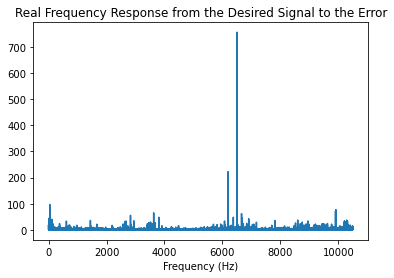

time: 766 ms (started: 2021-03-09 15:17:00 -05:00)


In [157]:
nlms_six_tap = NLMS(step_size=0.078, order=6)
outputs_n, weights_n, errors_n = nlms_six_tap.learn(u,d)

x, y = freq_response(errors_n, d, fs)

plt.plot(x,y)
plt.title('Real Frequency Response from the Desired Signal to the Error')
plt.xlabel('Frequency (Hz)')

#### Compute the SNR improvement in dB

In [158]:
'The SNR improvement after removing the noise using an order-6 NLMS filter is %s dB.' % ERLE(d, errors_n)

'The SNR improvement after removing the noise using an order-6 NLMS filter is 1.4268105763475765 dB.'

time: 32 ms (started: 2021-03-09 15:17:11 -05:00)


#### Evaluate the filter performance as a function of step size

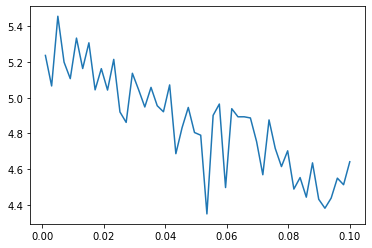

time: 5min 33s (started: 2021-03-09 15:37:08 -05:00)


In [180]:
reps = 10
steps = np.linspace(0.001, 0.1, num=50)
ERLEs = np.zeros((reps, len(steps)))

for i in range(reps):
    for j in range(len(steps)):
        nlms_two_tap = NLMS(step_size=steps[j], order=2)
        outputs_n, weights_n, errors_n = nlms_two_tap.learn(u,d)
        ERLEs[i,j] = ERLE(d, errors_n)
        
plt.plot(steps,ERLEs.mean(axis=0))

In [185]:
'For an order-2 NLMS filter, the step size that maximizes the ERLE is %s.' % round(steps[np.argmax(ERLEs.mean(axis=0))],4)

'For an order-2 NLMS filter, the step size that maximizes the ERLE is 0.005.'

time: 0 ns (started: 2021-03-09 15:44:48 -05:00)


In [187]:
nlms_two_tap = NLMS(step_size=0.005, order=2)
outputs_n, weights_n, errors_n = nlms_two_tap.learn(u,d)

time: 641 ms (started: 2021-03-09 15:51:04 -05:00)


In [188]:
ipd.Audio(errors_n, rate=fs) # load a NumPy array

time: 0 ns (started: 2021-03-09 15:51:23 -05:00)


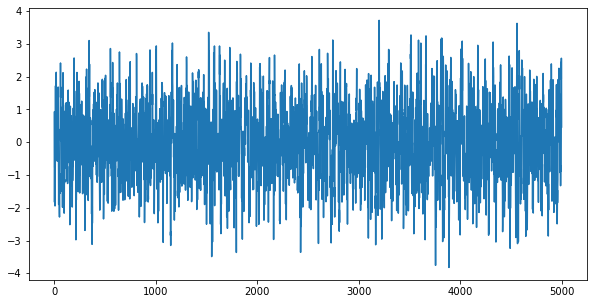

time: 203 ms (started: 2021-03-09 15:52:21 -05:00)


In [192]:
plt.figure(figsize=(10,5))
plt.plot(errors_n[5000:10000])

#### Estimate the misadjustment

In [186]:
'The estimated misadjustment is %s.' % nlms_misadjustment(u,0.005)

'The estimated misadjustment is 0.002676229319871764.'

time: 0 ns (started: 2021-03-09 15:49:50 -05:00)


#### Interpret these results and their relation to the convergence of the algorithm in non-stationary environments

In [ ]:
# add comments






# ADD COMMENTS !!!!!

### Implement a better filter, KLMS

In [ ]:
# now do klms...
# 2 tap grid search parameters for best performance

# pg 38 text... step size upper bound 1/g where  g = K(uj, uj)
sig = 0.1



klms_step(u[1000:5000])

In [ ]:
# plot weight tracks??? maybe not able to

In [ ]:
# plot learning curve

In [ ]:
# estimate frequency response

In [ ]:
# estimate snr improvement in db

In [ ]:
# increase filter order , grid search parameters

In [ ]:
# estimate the frequency resopnse

In [ ]:
# compute snr improvement 

In [ ]:
# evaluate filter performance as a finction of stepsize

In [ ]:
# estimate the misadjustment

In [ ]:
# Comment on the results obtained and address issues related to the convergence of the algorithm in nonstationary environments.
 